# Ground objects
This notebook grounds the mentioned objects in the painting using Grounding DINO and displays the annotated image.

### 0. Import libraries and load model

In [29]:
import time
import random

import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

In [30]:
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

### 1. Ground specified objects

In [36]:
def display_annotated_image(image, labels_scores_boxes):
    font = ImageFont.truetype("../../config/alata-regular.ttf", 18)
    draw = ImageDraw.Draw(image, "RGBA")

    for label, score, coords in labels_scores_boxes:
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF)) + "80"
        text_position = (coords[0] + 10, coords[1] + 5) 
        
        draw.rectangle(coords, outline=random_color, width=5)
        draw.text(text_position, label + " " + str(round(score, 2)), fill=random_color, font=font)

    display(image)

In [43]:
def detect_objects(image_id, text, processor, model, device, object_threshold=0.3, text_threshold=0.3):
    image = Image.open(f"../../data/raw/filtered_paintings/{image_id}.png")

    start_time = time.time()  

    inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        # threshold for filtering object detection predictions (lower -> more bounding boxes)
        threshold=object_threshold,
        # threshold for filtering text detection predictions (lower -> the input text is taken exactly)
        text_threshold=text_threshold,
        target_sizes=[image.size[::-1]]
    )

    assert len(results) == 1

    labels = results[0]["text_labels"]
    scores = results[0]["scores"].cpu().numpy()
    box_coordinates = [list(coords) for coords in results[0]["boxes"].cpu().numpy()]
    labels_scores_boxes = sorted(list(zip(labels, scores, box_coordinates)), key=lambda x:x[1])

    print(f"Duration: {round(time.time() - start_time, 2)}s")
    
    for label, score, coords in labels_scores_boxes:
        print(label, float(score), [float(coord) for coord in coords])
    
    display_annotated_image(image, labels_scores_boxes)
    
    return labels_scores_boxes

Duration: 1.8s
rocks 0.3050941228866577 [1.160651445388794, 0.9154484272003174, 999.134033203125, 1244.95166015625]
rocks 0.3103311359882355 [227.748046875, 981.6784057617188, 299.0061950683594, 1046.27197265625]
rocks 0.3240126967430115 [281.6848449707031, 1000.6541137695312, 360.26885986328125, 1067.888427734375]
rocks 0.3302229642868042 [446.172607421875, 942.9007568359375, 586.4544067382812, 1034.92333984375]
rocks 0.3422784209251404 [350.0409851074219, 970.2066650390625, 451.5265808105469, 1048.1331787109375]


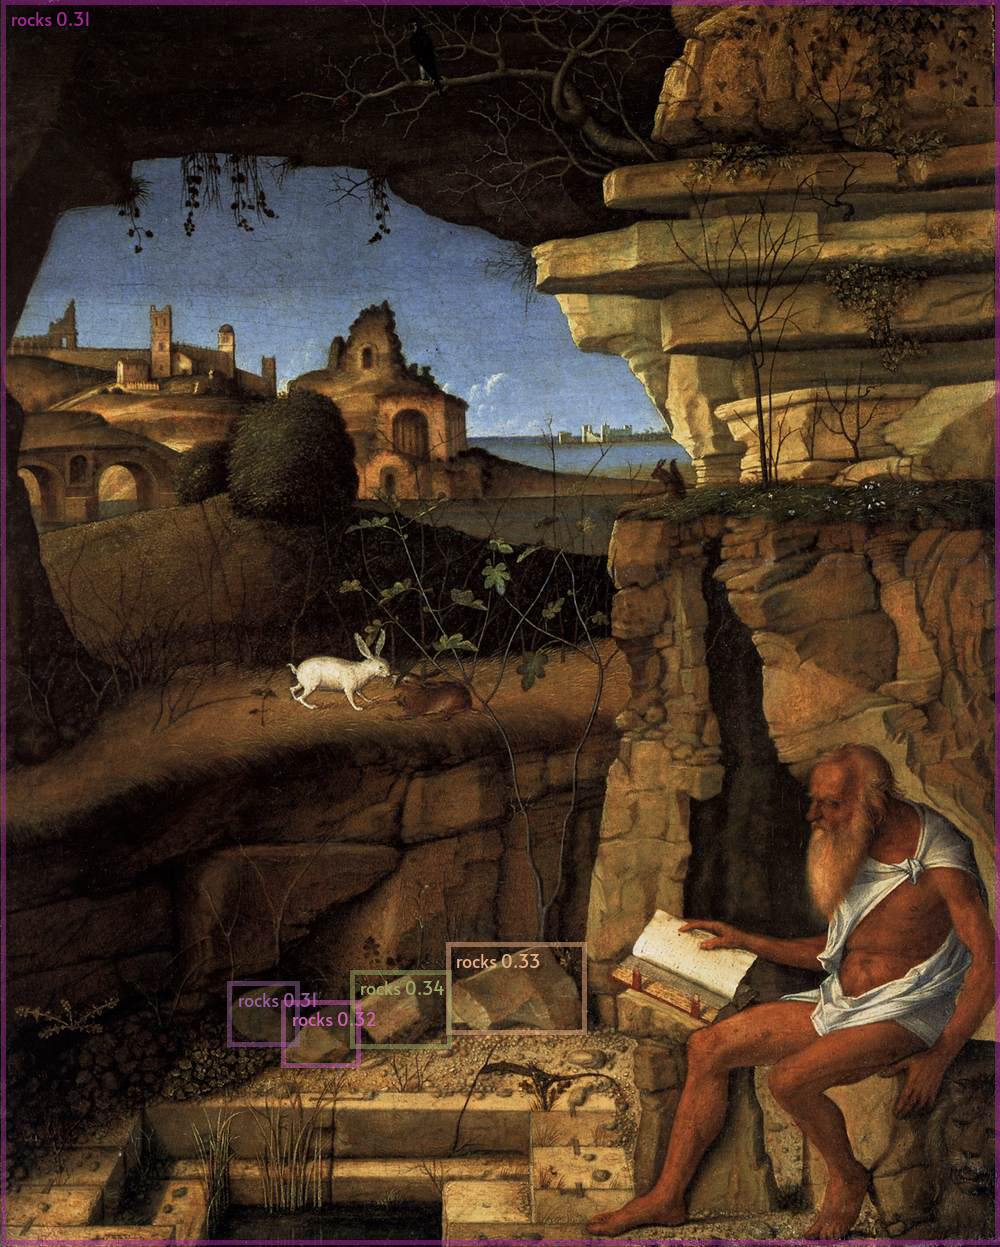

In [44]:
image_id = 3344
text = "rocks."

labels_scores_boxes = detect_objects(image_id, text, processor, model, device)